In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marribharadwaj","key":"3241c8e525e6737c6eab427082429dbe"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

ref                                                         title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                       Data Science Salaries 2023  💸                 25KB  2023-04-13 09:55:16           5990        147  1.0              
salvatorerastelli/spotify-and-youtube                       Spotify and Youtube                            9MB  2023-03-20 15:43:25          11522        403  1.0              
iammustafatz/diabetes-prediction-dataset                    Diabetes prediction dataset                  734KB  2023-04-08 06:11:45           3076         53  1.0              
shawkyelgendy/furniture-price-prediction                    Furniture Price Prediction                    81KB  202

In [ ]:
! kaggle competitions download -c Histopathologic Cancer Detection

usage: kaggle
       [-h]
       [-v]
       {competitions,c,datasets,d,kernels,k,config}
       ...
kaggle: error: unrecognized arguments: Detection


In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [02:44<00:00, 43.0MB/s]
100% 6.31G/6.31G [02:44<00:00, 41.1MB/s]


In [ ]:
import zipfile
import pandas as pd

# Extracting the .csv file from the zip file:
with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Importing all the necessary libraries and functions

In [ ]:
import numpy as np
import os

# Visualising using matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Importing PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Importing useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

# Loading Dataset

In [ ]:
# reading the training data into 'df'
df = pd.read_csv(r'train_labels.csv')
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


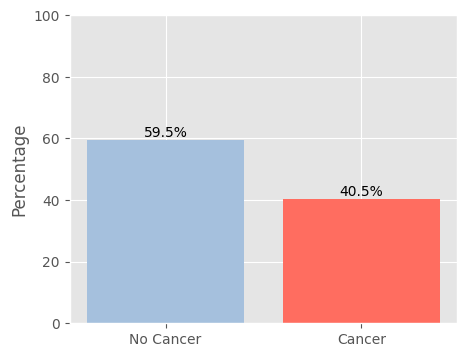

In [ ]:
# Creating bar chart of the distribution of dataset
labels_count = df.label.value_counts()

total = sum(labels_count)
percentages = [100 * count / total for count in labels_count]

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(['No Cancer', 'Cancer'], percentages, color=['#A5C0DD','#FF6D60'])

ax.set_ylabel('Percentage')
ax.set_ylim([0, 100])
for i, v in enumerate(percentages):
    ax.text(i, v+1, f'{v:.1f}%', ha='center')

plt.show()


In [ ]:
import os
base_dir = '/content'
print(os.listdir(base_dir))

['.config', 'kaggle.json', 'test', 'train_labels.csv', 'histopathologic-cancer-detection.zip', 'train', 'sample_submission.csv', 'sample_data']


Displaying train dataset images; with Label: 0 indicating normal (benign) and Label: 1 indicating cancerous

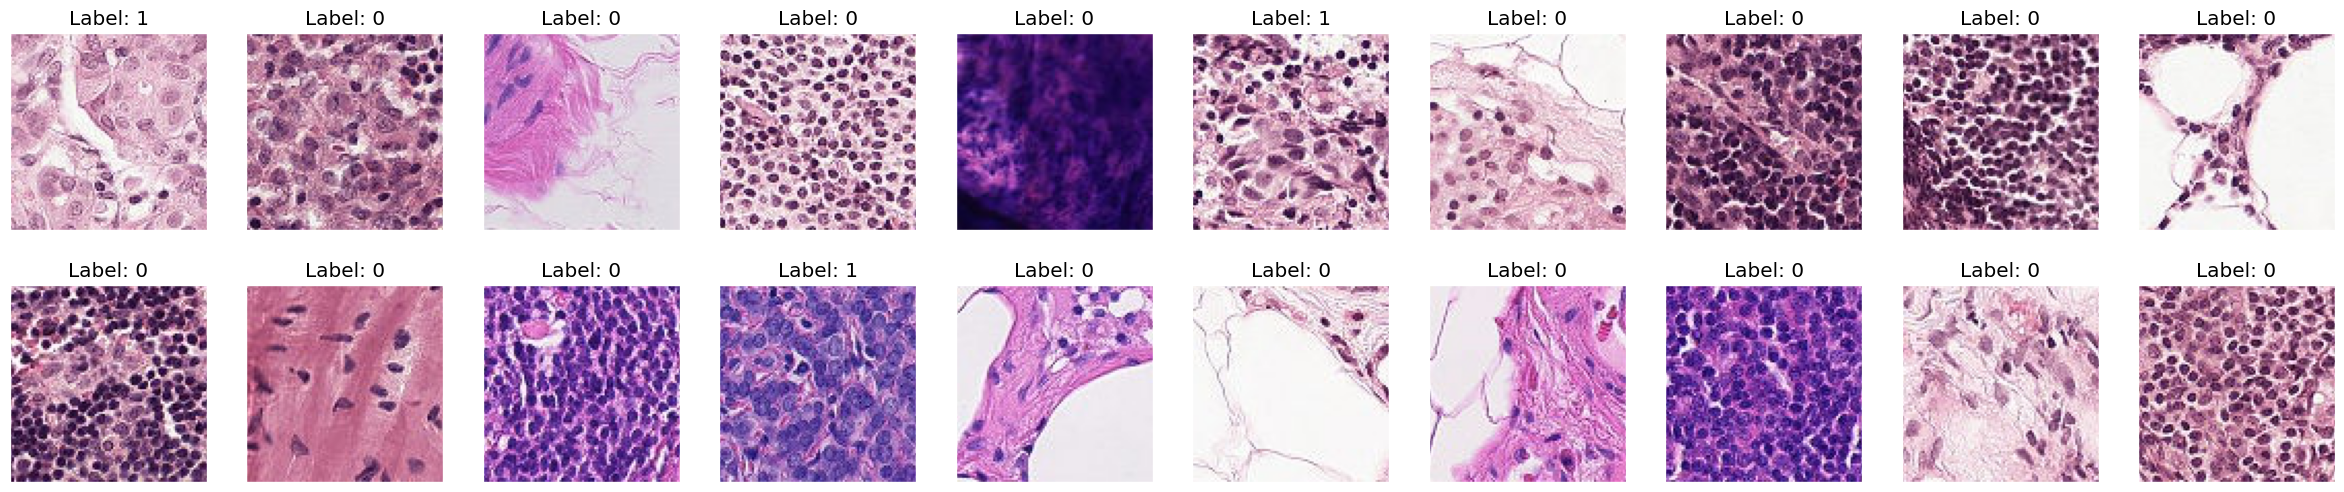

In [ ]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train/" + img)
    plt.imshow(im)
    lab = df.loc[df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

## Sampling Dataset

In [ ]:
# Spcifying sample size as 10000
sample_size = 10000

# Using 10000 positive and negative examples
df_negatives = df[df['label'] == 0].sample(sample_size, random_state=42)
df_positives = df[df['label'] == 1].sample(sample_size, random_state=42)

# Concatenating the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(20000, 2)

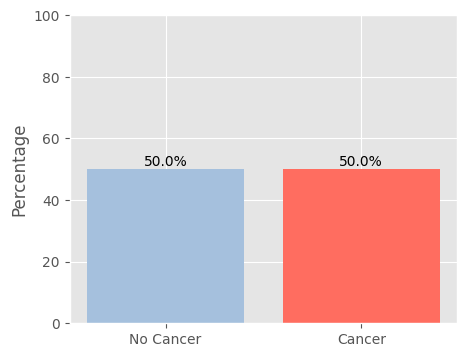

In [ ]:
# Creating bar chart of the distribution of sampled dataset
sampled_labels_count = train_df.label.value_counts()

total = sum(sampled_labels_count)
percentages = [100 * count / total for count in sampled_labels_count]

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(['No Cancer', 'Cancer'], percentages, color=['#A5C0DD','#FF6D60'])

ax.set_ylabel('Percentage')
ax.set_ylim([0, 100])
for i, v in enumerate(percentages):
    ax.text(i, v+1, f'{v:.1f}%', ha='center')

plt.show()


# Data Pre-processing for our PyTorch

In [ ]:
# Creating our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# transformations on our training data

transforms_train = transforms.Compose([transforms.ToPILImage(),transforms.RandomHorizontalFlip(p=0.4),transforms.RandomVerticalFlip(p=0.4),transforms.RandomRotation(20),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = CreateDataset(df_data=train_df, data_dir='/content/train', transform=transforms_train)

In [ ]:
# deciding the batch size
batch_size = 128

# 10% of the training dataset split as validation dataset
valid_size = 0.1
num_train = len(train_data)
indices = list(range(num_train))

# Dividing the population into clusters
num_clusters = 10
cluster_size = num_train // num_clusters
cluster_indices = [indices[i:i+cluster_size] for i in range(0, num_train, cluster_size)]

# Randomly selecting clusters for validation
valid_clusters = np.random.choice(range(num_clusters), int(num_clusters*valid_size), replace=False)
valid_idx = []
for cluster in valid_clusters:
    valid_idx.extend(cluster_indices[cluster])

# Remaining clusters will be alotted for training
train_clusters = list(set(range(num_clusters)) - set(valid_clusters))
train_idx = []
for cluster in train_clusters:
    train_idx.extend(cluster_indices[cluster])

# Making samples for training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Creating data loader and combining the dataset with sampled ones
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)


# Coding our Model

In [ ]:
# Defining our own CNN class
'''

For each 2D convoltional layer, we are spcifying number of input channels,
number of output channels, kernel size; and then normalising it. We used the
ReLU fucntion as out activation function for non-linearit. At last, we are
adding a 2D max pooling layer with kernel size fo 2 and stride of 2 to
downsample the output.
'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        # Define the convolutional and pooling layers using nn.Sequential()
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

        # Addinf a 2D dropout layer to avoid overfitting
        self.dropout2d = nn.Dropout2d()

        # fully connected layers
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())

    def forward(self,x):
        #Method for Forward Propogration
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
         # Applying dropout 2D layer to the output of the last convolutional layer
        x=self.dropout2d(x)
        # Flattening the output for the fully connected layers

        # Reshaping the tensor to have a 2D shape of (128, 51233)
        x=x.view(x.shape[0],-1)
        # Passing the flattened tensor through the fully connected layers
        x=self.fc(x)
        return x

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available: Training on CPU')
else:
    print('CUDA is available: Training on GPU')

CUDA is available: Training on GPU


## Training and Validation

In [ ]:
# creating a complete CNN
model = CNN()
print(model)

# Moving model to GPU as it is available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
'''

Specifying the loss function (categorical cross-entropy loss) as BCELoss:
BCE Loss works by creating an instance of the binary cross-entropy loss function.
The binary cross-entropy loss compares the predicted class probabilities to the
true class labels and calculates the error between them. This loss function is
well-suited for out binary classfication task as it measures the error in the
probabilities assigned to the two classes.

'''
criterion = nn.BCELoss()

'''

Specifing optimiser as Adam optimiser:
We have made an instance of the Adam optimiser, which is an extension of stochastic
gradient descent (SGD) optimization algorithm. The Adam optimiser updates the
parameters of the neural network model based on the gradients of the loss function
with respect to the parameters. The model.parameters() method provides a list of
all the learnable parameters in the model that need to be updated during training.
The lr parameter is the learning rate.

'''
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [ ]:
'''

We are training the our CNN model for 15 epochs using the training and validation
data loaders. In the beginning of the training loop, the training loss and
validation loss are set to 0. The model was then set to training mode and the
training data is iterated through in batches. The optimiser is zeroed, the CNN
model is passed the input data and the output is calculated. The criterion (loss)
is calculated and the gradient is propagated through the model using backpropagation.
The optimizer takes a step to update the weights of the model using the calculated
gradients. The training loss and accuracies are updated after each batch. After the
training, the CNN model is set to evaluation mode and validation data is iterated
through in batches. The input is passed to the model to get an output which is
compared with the target using the criterion (loss). The validation loss and AUC
(Area under the curve) are updated. The average losses and AUC are calculated for
each epoch, and the model with the lowest validation loss is saved. The training,
validation losses and AUC are printed at each epoch.

'''

n_epochs = 15
valid_loss_min = np.Inf

train_losses = []
valid_losses = []
train_acc = []
valid_acc = []
val_auc = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_valid = 0
    total_valid = 0
    model.train()

    for data, target in train_loader:
        data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    model.eval()
    for data, target in valid_loader:
        data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))
        _, predicted = torch.max(output.data, 1)
        total_valid += target.size(0)
        correct_valid += (predicted == target).sum().item()

    train_acc.append(100 * correct_train / total_train)
    valid_acc.append(100 * correct_valid / total_valid)

    # Calculating average losses and AUC
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {}; Training Loss: {:.5f}; Training Accuracy: {:.2f}%; Validation Loss: {:.5f}; Validation Accuracy: {:.2f}%; Validation AUC: {:.4f}'.format(epoch, train_loss, train_acc[-1] * 0.01, valid_loss, valid_acc[-1] * 0.01, valid_auc))

    # We are performing early stopping here. To elaborate, we are stopping the model
    # when the loss is validation falls below, this saving the best model.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased from {:.5f} to {:.5f}.  Saving the model.'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch: 1; Training Loss: 0.47663; Training Accuracy: 63.86%; Validation Loss: 0.40411; Validation Accuracy: 62.97%; Validation AUC: 0.9004
Validation loss decreased from inf to 0.40411.  Saving the model.
Epoch: 2; Training Loss: 0.41146; Training Accuracy: 63.86%; Validation Loss: 0.37874; Validation Accuracy: 63.04%; Validation AUC: 0.9071
Validation loss decreased from 0.40411 to 0.37874.  Saving the model.
Epoch: 3; Training Loss: 0.38715; Training Accuracy: 63.89%; Validation Loss: 0.34615; Validation Accuracy: 62.94%; Validation AUC: 0.9153
Validation loss decreased from 0.37874 to 0.34615.  Saving the model.
Epoch: 4; Training Loss: 0.36717; Training Accuracy: 63.89%; Validation Loss: 0.32616; Validation Accuracy: 62.87%; Validation AUC: 0.9211
Validation loss decreased from 0.34615 to 0.32616.  Saving the model.
Epoch: 5; Training Loss: 0.35216; Training Accuracy: 63.90%; Validation Loss: 0.33149; Validation Accuracy: 63.28%; Validation AUC: 0.9245
Epoch: 6; Training Loss: 0.33

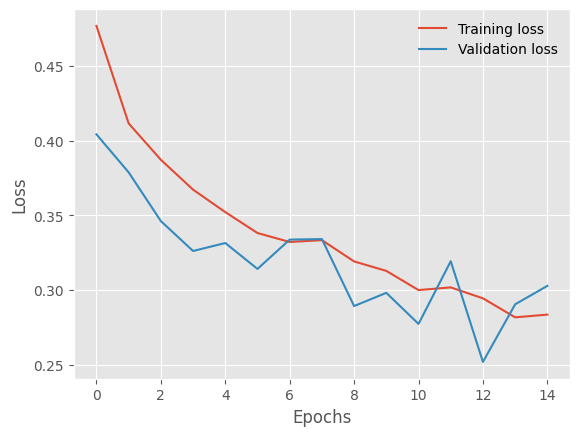

In [ ]:
# Plotting the Training Loss and Validation Loss across epochs

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

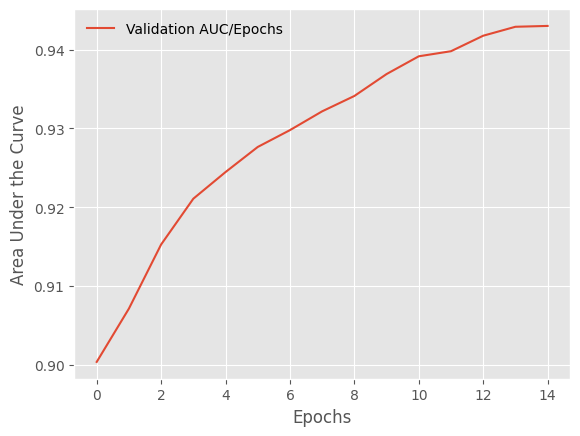

In [ ]:
# Plotting the Area Under the Curve (AUC) across epochs

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [ ]:
# Loading best parameters learned from training into our model to make predictions
# later

model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

## Test Dataset and its Predictions

In [ ]:
# Transformations on testing dataset and loading it

transforms_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

sample_sub = pd.read_csv("sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir='/content/test', transform=transforms_test)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Evaluating our CNN Model and predicting the classes of the Images
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

sample_sub['label'] = preds

In [ ]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i])

<ipython-input-38-717260dba54c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_sub.label[i] = np.float(sample_sub.label[i])


In [ ]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.155274
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.818927
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.076099
3,2c35657e312966e9294eac6841726ff3a748febf,0.067315
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.075839


# Displaying the Predictions

In [ ]:
# Creating a function to unnormalise and convert from Tensor image and display it

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

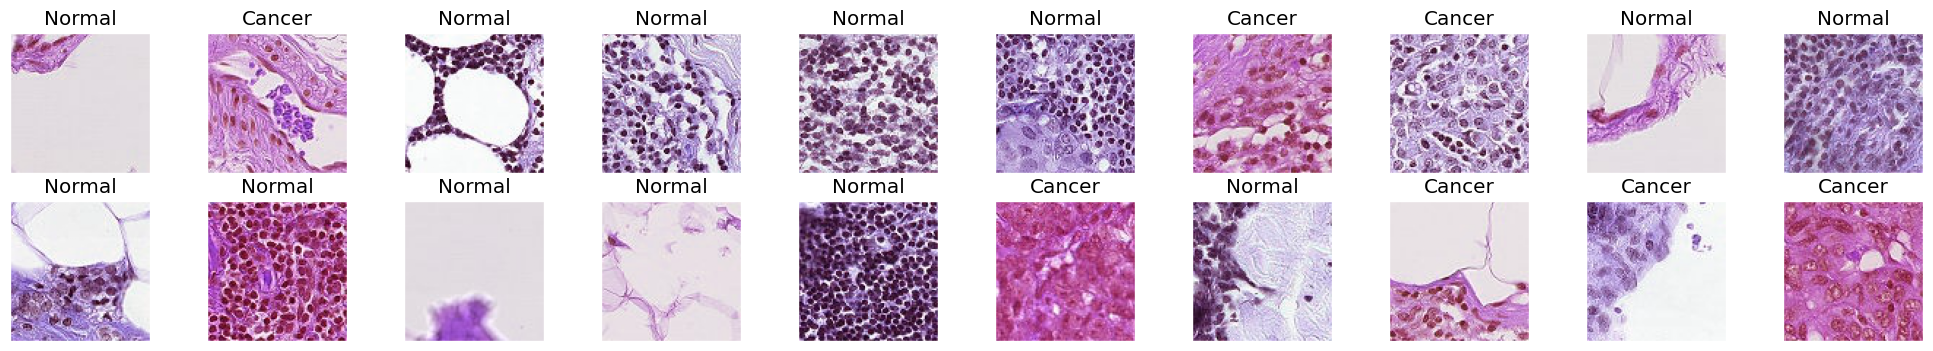

In [ ]:
# Displaying the images with predicted class as normal (benign) or cancerous
dataiter = iter(test_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    prob = "Cancer" if(sample_sub.label[idx] >= 0.5) else "Normal"
    ax.set_title('{}'.format(prob))

### Accuracy of Cluster Sampling + our CNN Model

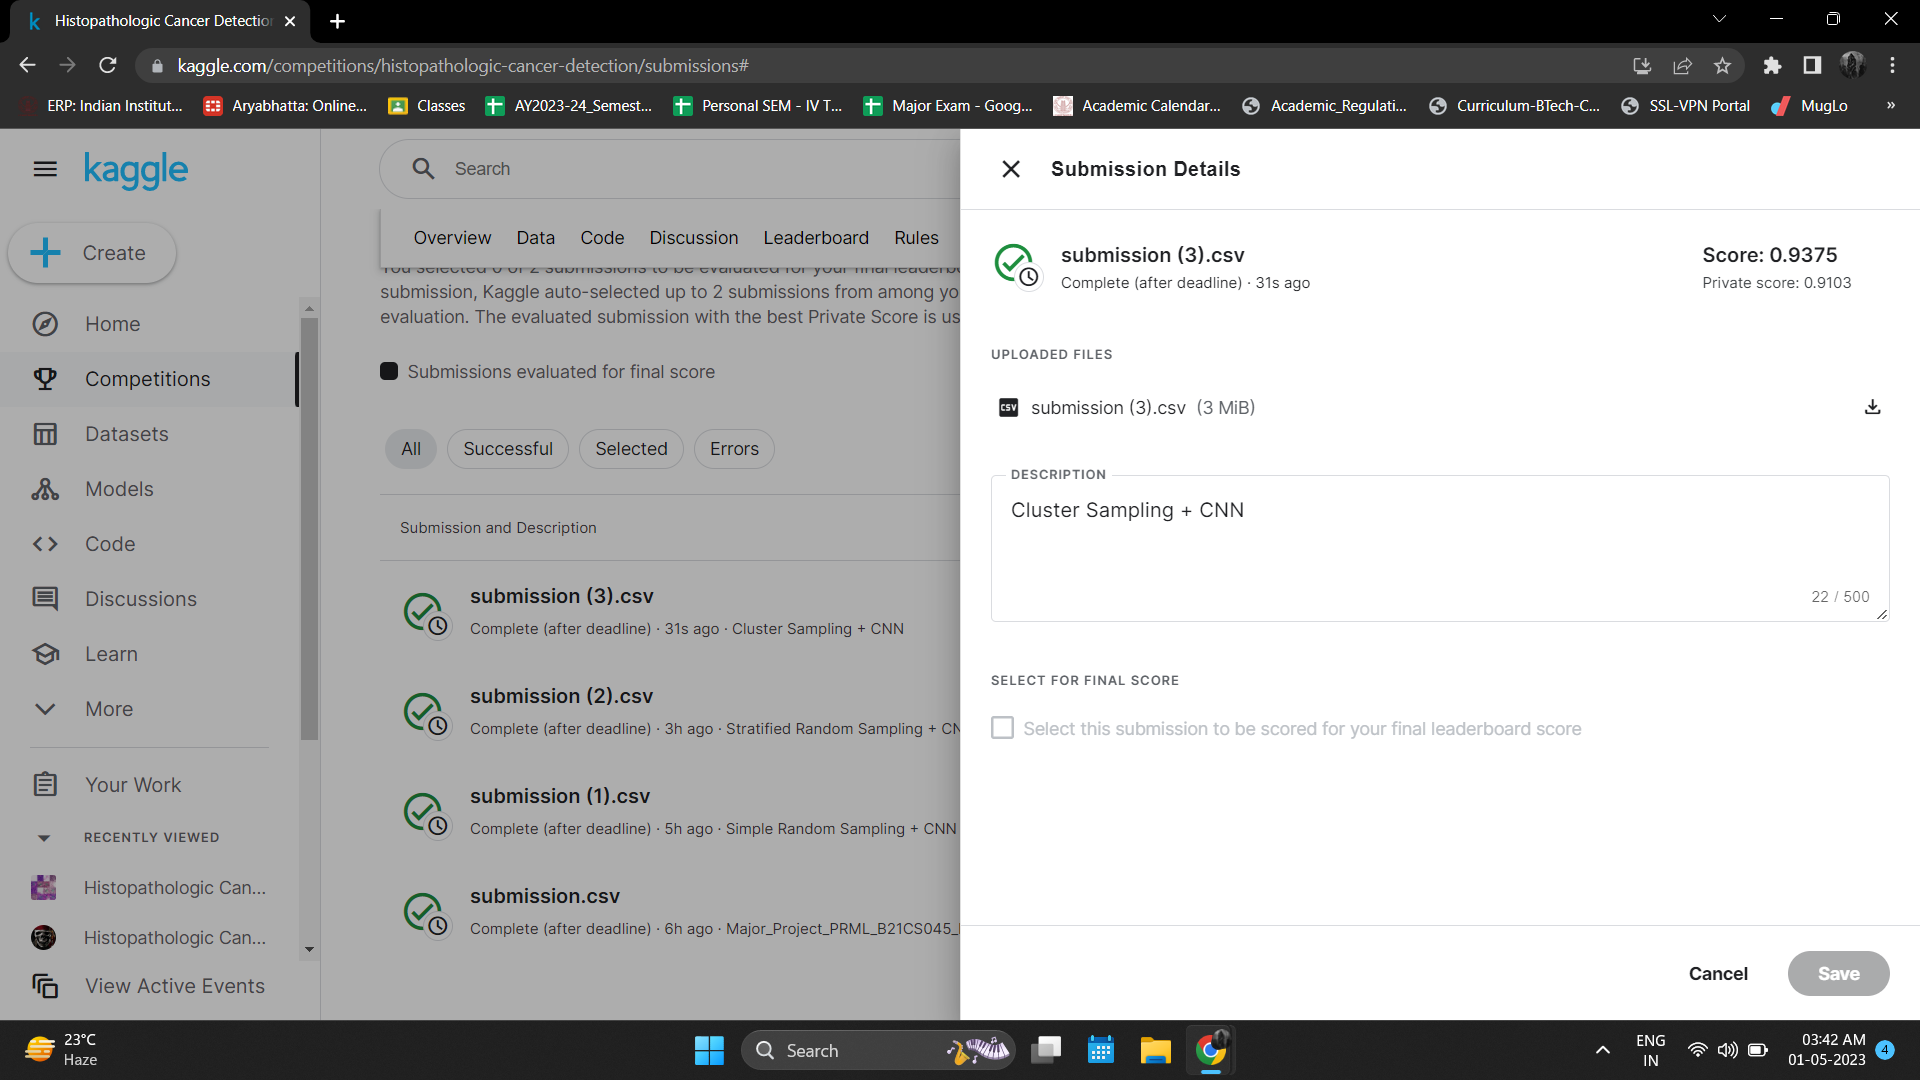

We have acquired an impressive accuracy of 93.75 % on our Convolutional Neural Networks (CNN) Model after performing Cluster Sampling!